In [ ]:
!pip install tensorflow-gpu==2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0


In [ ]:
!pip install wandb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

2.12.0


In [ ]:
import wandb
from wandb.keras import WandbCallback

!wandb login 69f60a7711ce6b8bbae91ac6d15e45d6b1f1430e

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import os
import cv2
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Pool2_path = '/content/drive/MyDrive/NR'
dir = os.listdir(Pool2_path)
Pool2 = []
for i in range(len(dir)):
   img = cv2.imread(Pool2_path+'/'+dir[i])
   img = cv2.resize(img,(64,64))
   Pool2.append(img)
Pool2 = np.array(Pool2)
print(Pool2.shape, 'Unlabeled Pool2.shape')
Pool2_train = Pool2[:7000]
Pool2_test = Pool2[7000:]
print(Pool2_train.shape[0], 'train samples')
print(Pool2_test.shape[0], 'test samples')

(7744, 64, 64, 3) Unlabeled Pool2.shape
7000 train samples
744 test samples


In [ ]:
Pool2_train = Pool2[:7000]
Pool2_test = Pool2[7000:]
print(Pool2_train.shape[0], 'train samples')
print(Pool2_test.shape[0], 'test samples')

7000 train samples
744 test samples


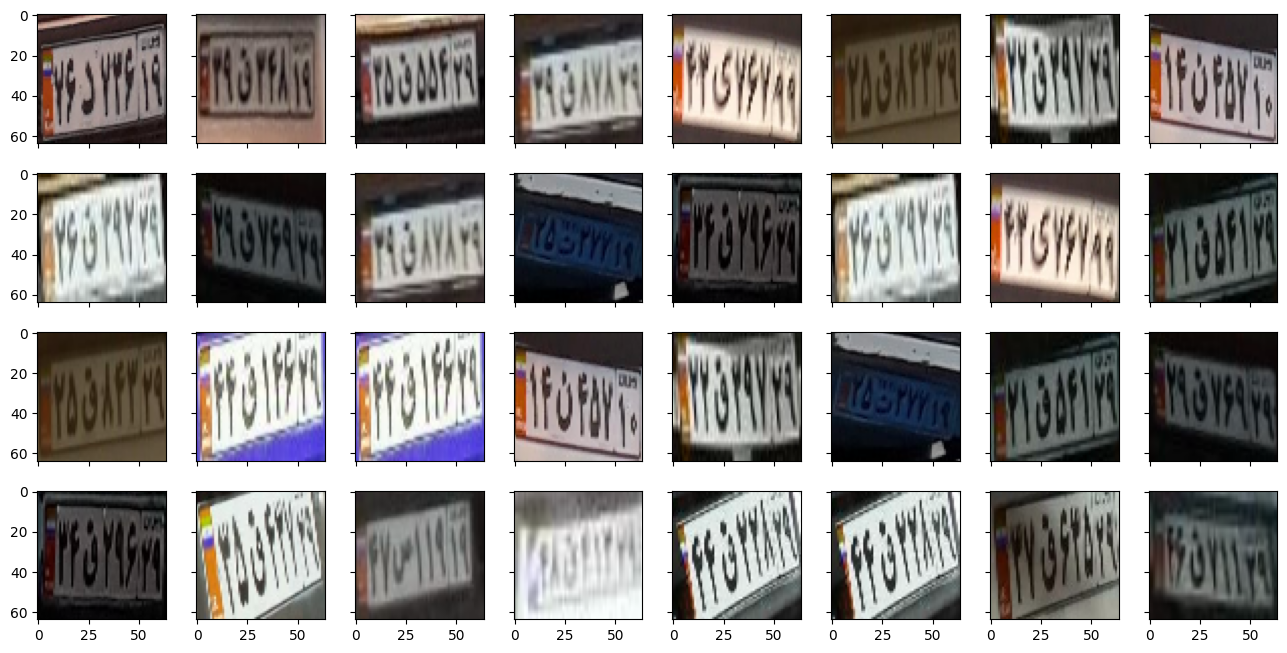

In [ ]:
sample_images = Pool2_train[:32]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image,cmap='gray')

plt.show()

In [ ]:
from tensorflow import keras

In [ ]:
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=32, dim=(64, 64), n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size
      self.X = X
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle

      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # X_batch is a matrix of masked images used as input
    X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image

    ## Iterate through random indexes
    for i, idx in enumerate(idxs):
      image_copy = self.X[idx].copy()

      ## Get mask associated to that image
      masked_image = self.__createMask(image_copy)

      X_batch[i,] = masked_image/255
      y_batch[i] = self.y[idx]/255

    return X_batch, y_batch

  def __createMask(self, img):
    ## Prepare masking matrix
    mask = np.full((64,64,3), 255, np.uint8)
    for _ in range(np.random.randint(1, 10)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(1, 32), np.random.randint(1, 32)
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, 32), np.random.randint(1, 32)
      # Get random thickness of the line drawn
      thickness = np.random.randint(1, 3)
      # Draw black line on the white mask
      cv2.line(mask,(x1,y1),(x2,y2),(1,1,1),thickness)

    # Perforn bitwise and operation to mak the image
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

In [ ]:
traingen = createAugment(Pool2_train, Pool2_train)
testgen = createAugment(Pool2_test, Pool2_test)

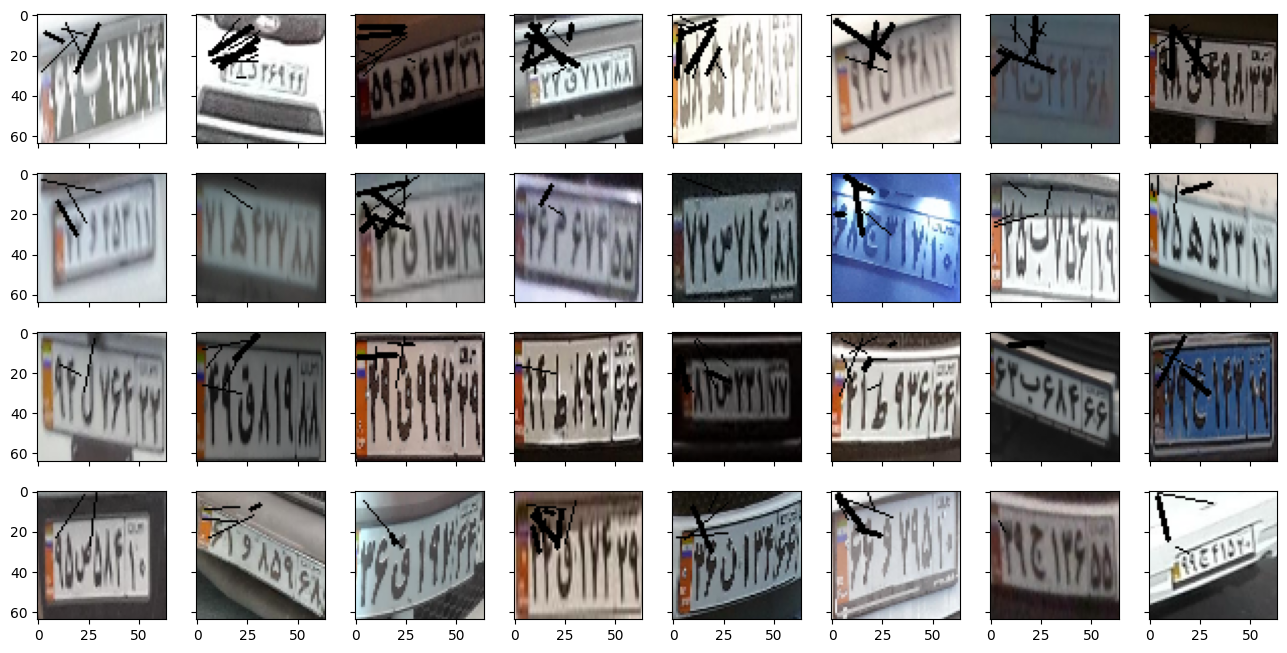

In [ ]:
## Examples
sample_idx = 5 ## Change this to see different batches

sample_images, sample_labels = traingen[sample_idx]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image,cmap='gray')

plt.show()

In [ ]:
def unet_like():
  inputs = keras.layers.Input((64, 64,3))
  conv1 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
  conv1 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
  pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
  conv2 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
  pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
  conv3 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
  pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
  conv4 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
  pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)
  conv5 = keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
  conv5 = keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

  up6 = keras.layers.concatenate([keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
  conv6 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
  conv6 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
  up7 = keras.layers.concatenate([keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
  conv7 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
  conv7 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
  up8 = keras.layers.concatenate([keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
  conv8 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
  conv8 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
  up9 = keras.layers.concatenate([keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
  conv9 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
  conv9 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
  conv10 = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

  return keras.models.Model(inputs=[inputs], outputs=[conv10])

In [ ]:
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) + 1)

In [ ]:
keras.backend.clear_session()
model = unet_like()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 64)   0           ['conv2d_1[0][0]']               
                                                                                              

In [ ]:
wandb.init(entity='ayush-thakur', project="image-impainting")

wandb: Currently logged in as: ayush-thakur. Use `wandb login --relogin` to force relogin


In [ ]:
model.fit(traingen, validation_data=testgen,
          epochs=20,
          steps_per_epoch=len(traingen),
          validation_steps=len(testgen),
          use_multiprocessing=True,
          callbacks=[WandbCallback()])

Train for 31 steps, validate for 25 steps
Epoch 1/20
31/31 [==============================] - 557s 18s/step - loss: 0.6126 - dice_coef: 0.6016 - val_loss: 0.5559 - val_dice_coef: 0.6588
Epoch 2/20
31/31 [==============================] - 552s 18s/step - loss: 0.5468 - dice_coef: 0.6370 - val_loss: 0.5243 - val_dice_coef: 0.7003
Epoch 3/20
31/31 [==============================] - 554s 18s/step - loss: 0.5336 - dice_coef: 0.6492 - val_loss: 0.5170 - val_dice_coef: 0.7106
Epoch 4/20
31/31 [==============================] - 558s 18s/step - loss: 0.5294 - dice_coef: 0.6524 - val_loss: 0.5151 - val_dice_coef: 0.7196
Epoch 5/20
31/31 [==============================] - 556s 18s/step - loss: 0.5280 - dice_coef: 0.6534 - val_loss: 0.5134 - val_dice_coef: 0.7184
Epoch 6/20
31/31 [==============================] - 552s 18s/step - loss: 0.5265 - dice_coef: 0.6549 - val_loss: 0.5122 - val_dice_coef: 0.7123
Epoch 7/20
31/31 [==============================] - 555s 18s/step - loss: 0.5265 - dice_coef: 

In [ ]:
acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']

loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 151ms/step


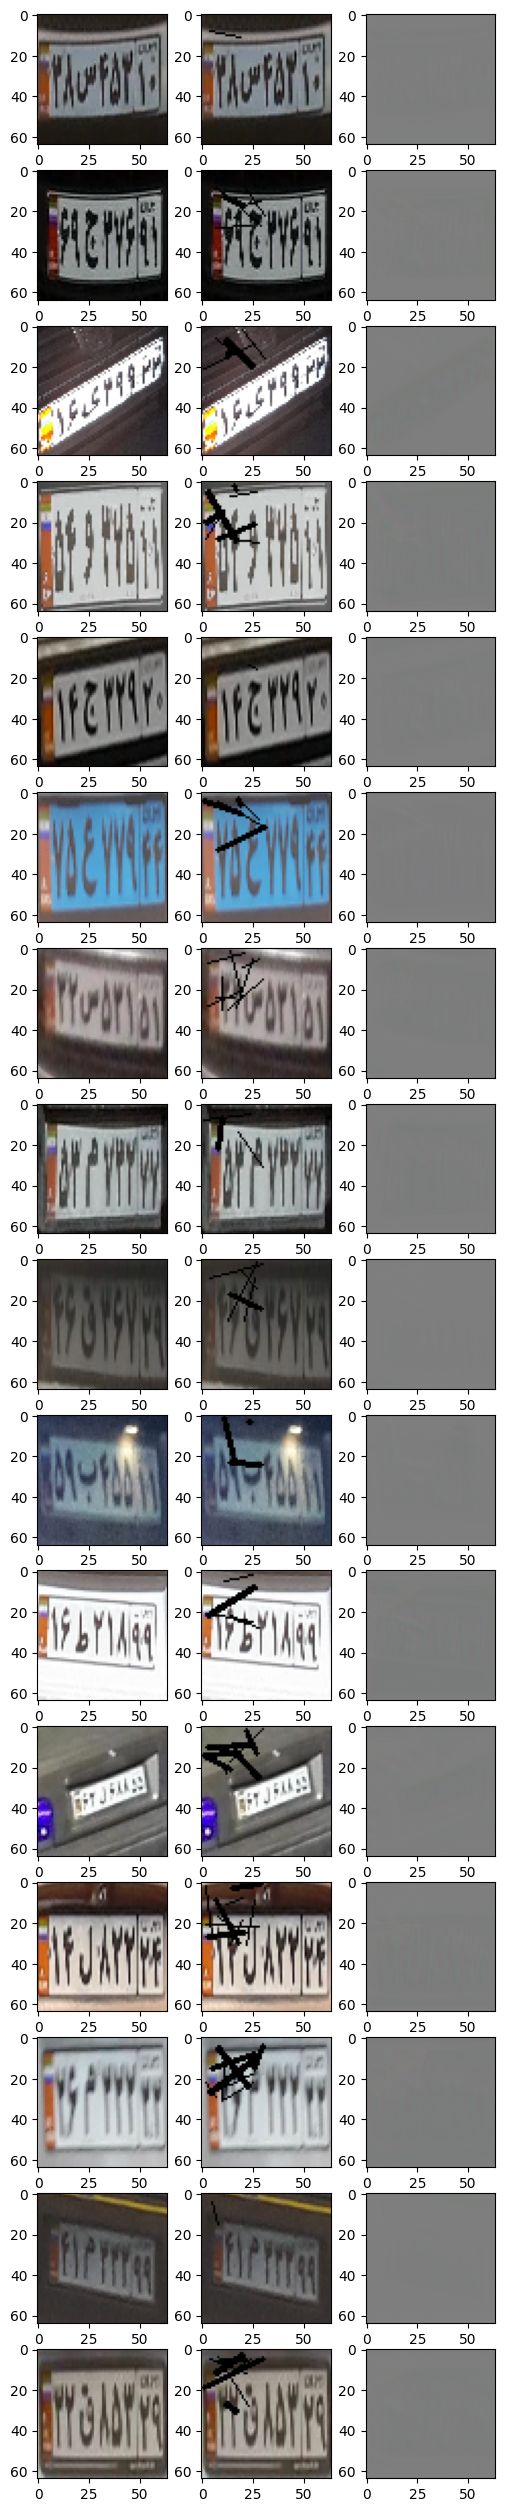

In [ ]:
## Examples
rows = 16
sample_idx = np.random.randint(0, len(testgen), rows)

fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(6, 32))

for i, idx in enumerate(sample_idx):
  sample_images, sample_labels = traingen[idx]
  img_idx = np.random.randint(0, len(sample_images)-1, 1)[0]
  impainted_image = model.predict(sample_images[img_idx].reshape((1,)+sample_images[img_idx].shape))
  axs[i][0].imshow(sample_labels[img_idx])
  axs[i][1].imshow(sample_images[img_idx])
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))

plt.show()

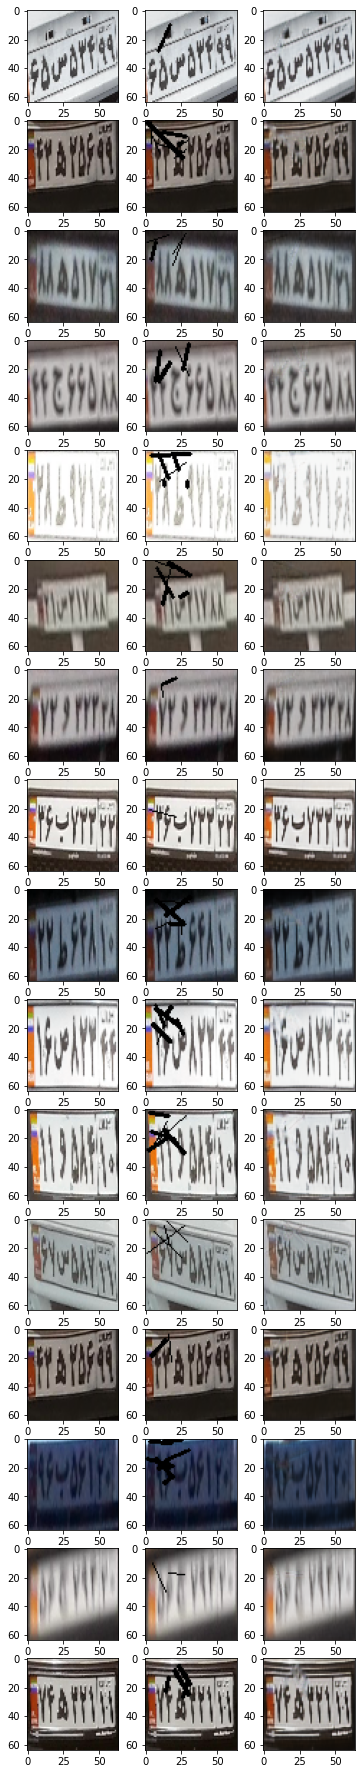

In [ ]:
## Examples
rows = 16
sample_idx = np.random.randint(0, len(testgen), rows)

fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(6, 32))

for i, idx in enumerate(sample_idx):
  sample_images, sample_labels = traingen[idx]
  img_idx = np.random.randint(0, len(sample_images)-1, 1)[0]
  impainted_image = model.predict(sample_images[img_idx].reshape((1,)+sample_images[img_idx].shape))
  axs[i][0].imshow(sample_labels[img_idx])
  axs[i][1].imshow(sample_images[img_idx])
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))

plt.show()